<h2 align="left"><font color=#ed2f00>Let's get started:</font></h2>

<a id="Initialization"></a>
# <p style="background-color: #ed2f00; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 1 | Setup and Initialization</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [1]:
# Install Ultralytics library
!pip install -U ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/7f/dd/bc774bf620a5adf26154301ddd043f1f6eb967247b08070e8df4f7f3a668/ultralytics-8.3.31-py3-none-any.whl.metadata
  Obtaining dependency information for ultralytics-thop>=2.0.0 from https://files.pythonhosted.org/packages/d7/ec/3650362c6cd72f0a2a9d840cbe7a136ceea6e06b02bb7088a4f436accc5c/ultralytics_thop-2.0.11-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 15.3 MB/s eta 0:00:00a 0:00:01


In [2]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import yaml
from PIL import Image
from collections import deque
from ultralytics import YOLO
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#ffe4de'}, style='darkgrid')

<a id="Load_Model"></a>
# <p style="background-color: #ed2f00; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 2 | Loading YOLO11-seg Pre-trained Model</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [6]:

# Load the pre-trained YOLOv8 nano segmentation model
model = YOLO('yolo11n-seg.pt') 

100%|██████████| 5.90M/5.90M [00:00<00:00, 15.8MB/s]


<a id="Dataset_Exploration"></a>
# <p style="background-color: #ed2f00; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 3 | Dataset Exploration</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [7]:
# Wandb login:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("wandb_api_key")
wandb.login(key=secret_value)
settings=wandb.Settings(disable_job_creation=True)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
# Define the dataset_path
dataset_path = '/kaggle/input/dentalcariesv1/seg_detection_caries'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- caries
nc: 1
roboflow:
  license: CC BY 4.0
  project: coco_caries
  url: https://universe.roboflow.com/cocoyaml/coco_caries/dataset/2
  version: 2
  workspace: cocoyaml
train: ../train/images
val: ../valid/images



In [9]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 2463
Number of validation images: 205
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


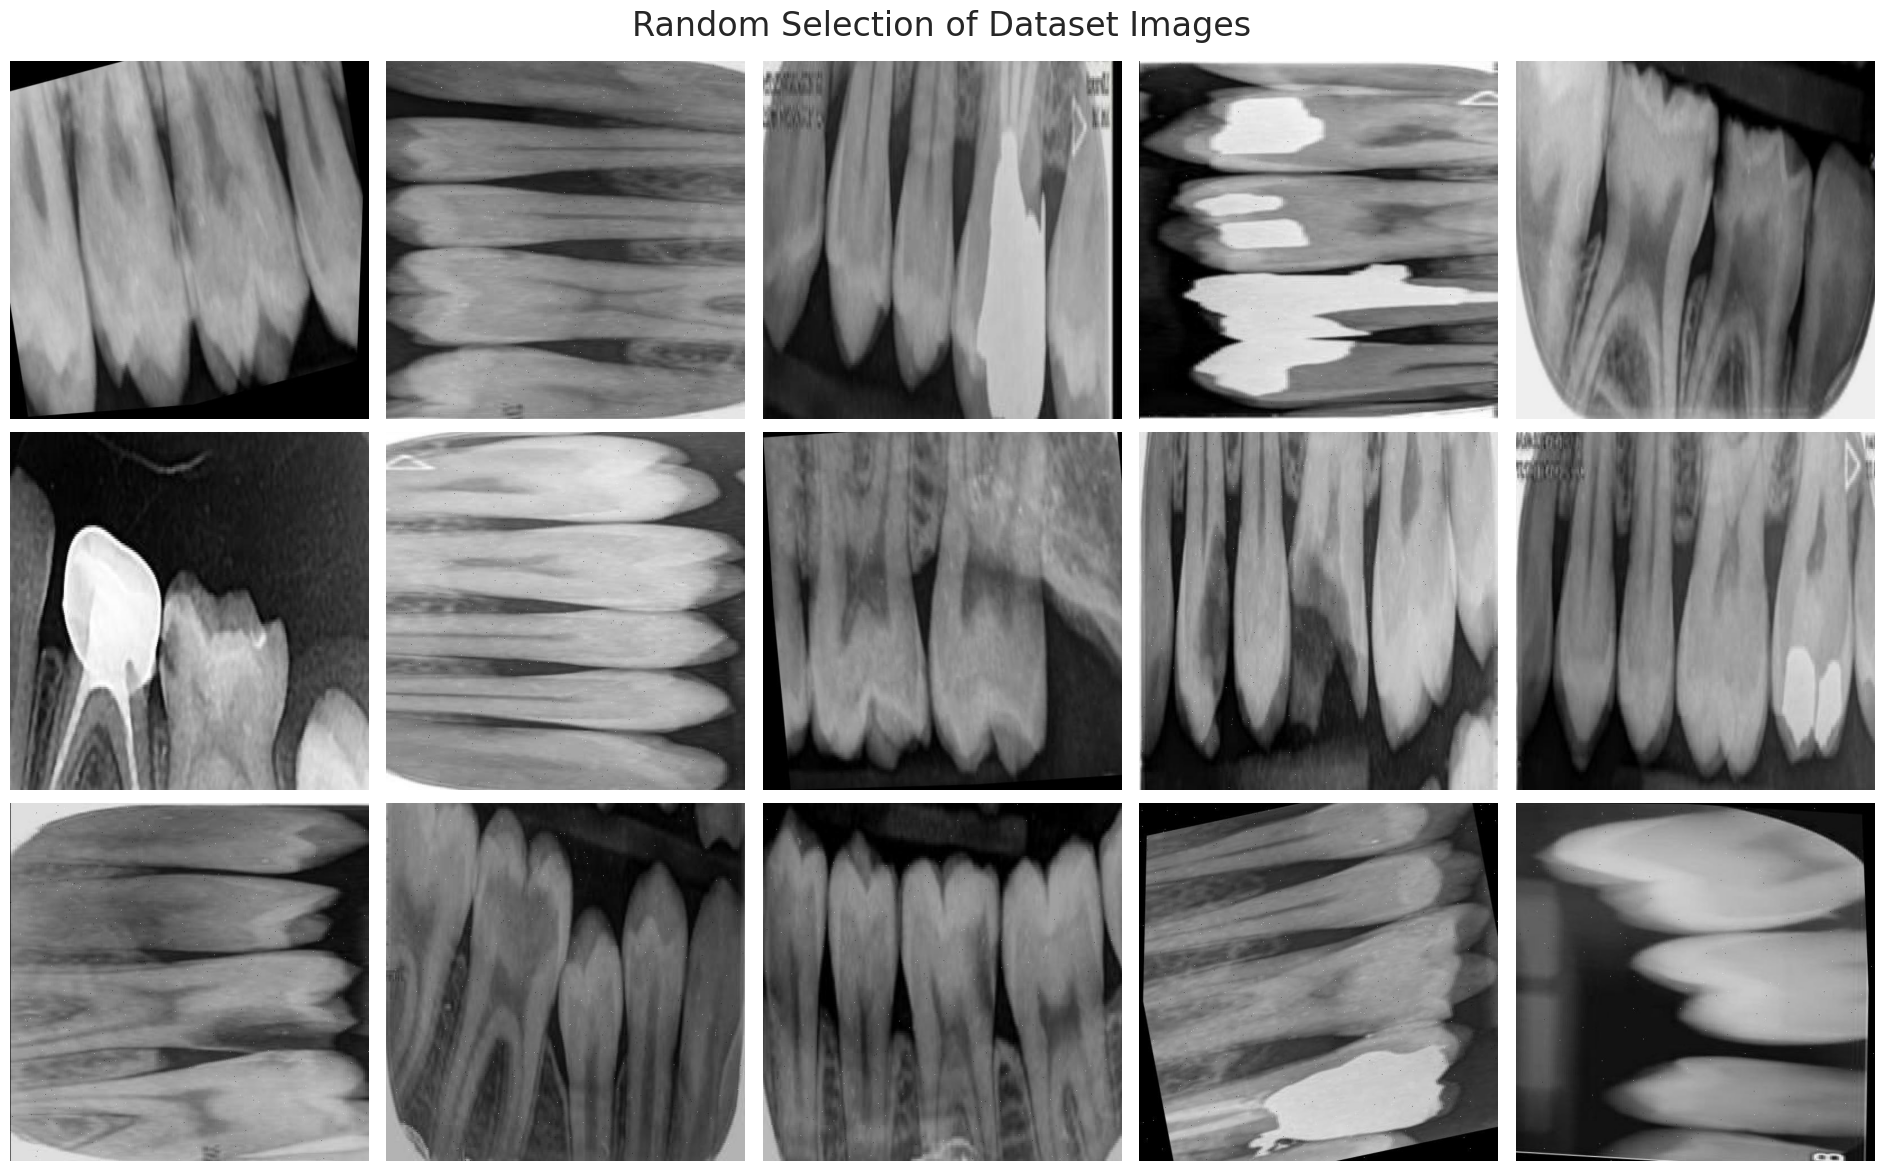

In [10]:
# Set the seed for the random number generator
random.seed(0)

# Create a list of image files
image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]

# Randomly select 15 images
random_images = random.sample(image_files, 15)

# Create a new figure
plt.figure(figsize=(19, 12))

# Loop through each image and display it in a 3x5 grid
for i, image_file in enumerate(random_images):
    image_path = os.path.join(train_images_path, image_file)
    image = Image.open(image_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

# Add a suptitle
plt.suptitle('Random Selection of Dataset Images', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()

# Deleting unnecessary variable to free up memory
del image_files

<a id="Fine_Tuning"></a>
# <p style="background-color: #ed2f00; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 4 | Fine-Tuning YOLO11-seg</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [11]:
!pip install -U ray[tune]

  Obtaining dependency information for ray[tune] from https://files.pythonhosted.org/packages/56/41/df809b6a516c0285f7d9aaeefd040910df088508d5471f85e0409f52f070/ray-2.39.0-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 18.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.6.3
    Uninstalling ray-2.6.3:
      Successfully uninstalled ray-2.6.3


In [12]:
# Train the model on our custom dataset
results = model.train(
    data=yaml_file_path,     # Path to the dataset configuration file
    epochs=200,              # Number of epochs to train for
    imgsz=640,               # Size of input images as integer
    patience=20,             # Epochs to wait for no observable improvement for early stopping of training
    batch=16,                # Number of images per batch
    optimizer='auto',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
    lr0=0.0001,              # Initial learning rate 
    lrf=0.01,                # Final learning rate (lr0 * lrf)
    dropout=0.25,            # Use dropout regularization
    device=0,                # Device to run on, i.e. cuda device=0 
    seed=42                  # Random seed for reproducibility
)

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/kaggle/input/dentalcariesv1/seg_detection_caries/data.yaml, epochs=200, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.25, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

100%|██████████| 755k/755k [00:00<00:00, 3.72MB/s]
2024-11-14 12:53:23,434	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-14 12:53:23,712	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/dentalcariesv1/seg_detection_caries/train/labels... 2463 images, 0 backgrounds, 14 corrupt: 100%|██████████| 2463/2463 [00:05<00:00, 458.86it/s]

train: WARNING ⚠️ /kaggle/input/dentalcariesv1/seg_detection_caries/train/images/Screenshot-2023-11-19-at-5-19-51-PM_png_jpg.rf.948de9525e373d161f4bf6922c209b88.jpg: ignoring corrupt image/label: cannot reshape array of size 43 into shape (2)
train: WARNING ⚠️ /kaggle/input/dentalcariesv1/seg_detection_caries/train/images/Screenshot-2023-11-20-at-11-26-09-PM_png_jpg.rf.14d6bfdde212ef4d2061caf98a6473df.jpg: ignoring corrupt image/label: cannot reshape array of size 77 into shape (2)
train: WARNING ⚠️ /kaggle/input/dentalcariesv1/seg_detection_caries/train/images/Screenshot-2023-11-20-at-11-26-09-PM_png_jpg.rf.eba66f91c5d9621168e5f1c2706b6eda.jpg: ignoring corrupt image/label: cannot reshape array of size 77 into shape (2)
train: WARNING ⚠️ /kaggle/input/dentalcariesv1/seg_detection_caries/train/images/Screenshot-2023-11-24-at-1-12-32-AM_png_jpg.rf.b626e1238b09f611673bc924822d1759.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 1. Possible class labels are 0-

train: WARNING ⚠️ Cache directory /kaggle/input/dentalcariesv1/seg_detection_caries/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/dentalcariesv1/seg_detection_caries/valid/labels... 205 images, 0 backgrounds, 2 corrupt: 100%|██████████| 205/205 [00:00<00:00, 394.18it/s]

val: WARNING ⚠️ /kaggle/input/dentalcariesv1/seg_detection_caries/valid/images/Screenshot-2023-11-16-at-12-27-47-AM_png_jpg.rf.8b2438d7e32a663c3f43501dee323b20.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/input/dentalcariesv1/seg_detection_caries/valid/images/Screenshot-2023-11-27-at-12-15-06-PM_png_jpg.rf.200d208b599f2a7705dfbf5c69386572.jpg: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ Cache directory /kaggle/input/dentalcariesv1/seg_detection_caries/valid is not writeable, cache not saved.


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.37G      2.445      3.984      3.874      1.843          4        640: 100%|██████████| 154/154 [00:54<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        203        372       0.13      0.159     0.0491     0.0127      0.102      0.175     0.0344     0.0077



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.36G      2.316      3.467      2.665       1.75          0        640: 100%|██████████| 154/154 [00:49<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        203        372      0.338      0.328      0.257     0.0815      0.358      0.239      0.211     0.0591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.46G      2.293        3.4       2.25      1.742          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        203        372      0.184      0.172      0.106     0.0322      0.175      0.151      0.111     0.0315



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200       3.8G      2.271       3.37      2.115       1.73          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372      0.122      0.102     0.0565     0.0138      0.102      0.102     0.0488     0.0127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.31G      2.244      3.291      2.055      1.705          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        203        372      0.376      0.309      0.284      0.102       0.35      0.288      0.267     0.0866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.42G       2.14      3.152      1.931      1.637          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        203        372      0.345      0.344      0.285     0.0907      0.334      0.333      0.239      0.079



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.38G      2.174      3.199      1.953      1.654          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        203        372      0.389      0.382      0.343      0.124      0.389      0.309      0.274      0.092



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.33G      2.127      3.116      1.843      1.625          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        203        372      0.401      0.328      0.315      0.121       0.38      0.331      0.302      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.38G      2.083      3.093      1.782      1.595          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372      0.535      0.473      0.469      0.176      0.513      0.449      0.438      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200       3.4G      2.049      3.048      1.763      1.581          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        203        372      0.474      0.519      0.448      0.155      0.495      0.495      0.436       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.34G      2.064      3.017      1.758       1.57          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        203        372      0.417      0.417      0.394      0.162      0.441      0.403       0.38      0.138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.38G      2.005      2.944      1.667      1.538          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        203        372      0.559      0.468      0.523      0.212      0.599      0.438       0.49      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.42G      2.004      2.941      1.683      1.539          7        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        203        372      0.478      0.352      0.365      0.141      0.466      0.343      0.347      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.49G      2.004      2.969      1.671      1.536          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        203        372      0.491      0.446       0.42      0.167      0.461      0.411      0.377      0.141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.42G      1.976      2.902       1.63      1.516          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        203        372      0.566      0.567      0.564      0.234      0.568       0.54      0.533      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.79G      1.982      2.916      1.611      1.509          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        203        372      0.526      0.473      0.471      0.187      0.506      0.452      0.443      0.163



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.32G      1.974      2.936      1.617      1.534          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        203        372      0.538      0.513      0.518      0.216      0.514      0.481      0.476      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.36G       1.93      2.865      1.549      1.491          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        203        372      0.614      0.516      0.564      0.265      0.591      0.476      0.509      0.206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.77G      1.937      2.845       1.57      1.499          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        203        372      0.539      0.497      0.491      0.217      0.551      0.473      0.485      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.39G      1.916      2.873      1.556       1.47          4        640: 100%|██████████| 154/154 [00:49<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        203        372      0.518      0.446      0.448      0.189       0.54      0.384      0.404      0.163



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.36G      1.893      2.828      1.491      1.453          5        640: 100%|██████████| 154/154 [00:49<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        203        372      0.468      0.347      0.386       0.16       0.46      0.325      0.351      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.33G      1.886      2.823      1.502      1.455          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        203        372      0.518      0.484      0.486      0.214      0.498      0.465      0.462      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.35G      1.885      2.828      1.488      1.456          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        203        372      0.576      0.535      0.555      0.265      0.587      0.527      0.546      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.38G      1.882      2.806      1.489      1.459          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        203        372      0.443      0.446      0.424      0.189      0.426      0.425      0.388      0.164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.41G      1.902      2.823      1.492      1.451          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        203        372      0.541        0.5      0.524      0.232      0.526      0.487      0.506      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.37G      1.893      2.808      1.488      1.455          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        203        372      0.596      0.505      0.557      0.256      0.592      0.478      0.514      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.36G      1.823      2.758      1.437      1.423          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        203        372      0.657      0.551      0.582      0.286      0.642      0.522      0.555      0.242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200      3.35G      1.821      2.722       1.45      1.414          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372      0.635       0.54      0.579      0.256      0.625      0.543      0.574      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.38G      1.858      2.773       1.46      1.432          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        203        372      0.506      0.406      0.425      0.194       0.56      0.366      0.415      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.41G      1.831      2.743      1.415      1.413          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        203        372      0.631       0.57      0.621      0.293      0.654      0.554      0.614      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.33G      1.836      2.746      1.431      1.423          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        203        372      0.586      0.473       0.51      0.207       0.58      0.438      0.473       0.19



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.37G      1.809        2.7      1.388        1.4          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        203        372      0.635      0.605      0.647      0.293      0.627      0.583      0.618      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.42G      1.769      2.673      1.347      1.396          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        203        372      0.653      0.546      0.603      0.288      0.628      0.532      0.567      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.42G      1.805      2.712       1.37      1.405          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372      0.624      0.575      0.622      0.297      0.623      0.559      0.582      0.254



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200       3.4G      1.774      2.705      1.361      1.383          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        203        372      0.662      0.556       0.61      0.299      0.637      0.519      0.565      0.248



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.35G      1.741      2.639      1.343      1.355          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        203        372      0.591      0.505      0.544      0.263      0.609      0.474      0.531      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.36G      1.737       2.65      1.331      1.352          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        203        372      0.633      0.618      0.658      0.317      0.605      0.581      0.606      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.37G      1.741       2.65      1.291      1.363          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        203        372      0.648      0.545      0.576      0.271      0.612      0.513       0.55      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.35G      1.772      2.658      1.304      1.356          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        203        372      0.634      0.595      0.631      0.318       0.65      0.589      0.611      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.42G      1.762      2.649      1.323      1.374          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        203        372      0.617      0.548      0.542      0.252      0.653      0.505      0.538      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.31G       1.74      2.649      1.307      1.368          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        203        372      0.635      0.556       0.58      0.282      0.614      0.538      0.545      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.35G      1.727      2.625      1.298      1.355          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372      0.628      0.624      0.627      0.313      0.685      0.589      0.629      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.35G      1.707      2.598      1.283      1.337          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        203        372      0.695      0.532      0.648      0.299      0.685       0.49      0.605      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200       3.4G      1.708      2.604       1.28      1.337          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        203        372      0.628      0.591      0.614      0.305      0.617      0.554      0.584      0.259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200       3.4G      1.741      2.644       1.31      1.352          3        640: 100%|██████████| 154/154 [00:49<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        203        372      0.723      0.666      0.683      0.336       0.69      0.624      0.642       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.38G       1.73       2.65      1.297      1.358          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        203        372       0.69       0.57      0.622      0.297      0.672      0.535      0.593      0.258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.38G      1.711      2.609      1.269      1.366          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        203        372       0.74      0.556      0.683       0.34      0.744      0.522       0.64      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.39G        1.7      2.574      1.241      1.344          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        203        372      0.653      0.613      0.652      0.319      0.625      0.602      0.621      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.79G      1.677      2.566      1.228      1.324          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        203        372      0.674      0.683      0.698      0.373      0.705      0.624       0.67      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.37G      1.682      2.598      1.235      1.319          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        203        372      0.671      0.658      0.674      0.345      0.648      0.613       0.63      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.35G      1.675      2.553      1.208      1.303          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        203        372      0.753      0.605        0.7      0.363       0.72      0.583      0.664      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.42G      1.669      2.609      1.225      1.318          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        203        372      0.712      0.599      0.683      0.353      0.687      0.566      0.634      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.79G      1.671      2.558      1.206      1.311          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        203        372      0.734      0.629      0.699       0.36      0.704      0.615       0.65      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.41G      1.647       2.54      1.216      1.299          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        203        372      0.691      0.631      0.678      0.344      0.692       0.61      0.653      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.33G      1.628      2.508      1.171      1.306          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        203        372       0.78      0.651      0.731      0.385      0.759      0.628      0.692      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/200       3.3G      1.638      2.503      1.176      1.286          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        203        372      0.724      0.641      0.711      0.382      0.706       0.62      0.668      0.315



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.35G      1.631      2.508      1.172      1.303          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        203        372      0.727      0.686      0.721      0.379      0.685       0.64      0.667      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.41G      1.635      2.558      1.193      1.292          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        203        372      0.734      0.632      0.698      0.357      0.741      0.591      0.649      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.34G      1.617      2.495      1.176      1.286          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        203        372      0.694      0.676      0.693      0.367       0.67      0.628      0.648      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.39G      1.599      2.494      1.144      1.274          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        203        372      0.747      0.645      0.715      0.373      0.709       0.59      0.655      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.39G      1.614      2.502      1.185      1.287          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        203        372      0.745      0.626      0.703      0.366      0.729      0.622      0.671      0.298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.42G      1.599      2.492      1.136      1.267          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        203        372      0.696      0.656      0.717      0.364      0.685      0.618      0.668      0.298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.43G      1.594      2.492      1.128      1.265          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        203        372        0.7      0.632      0.681      0.339      0.659      0.594      0.626      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.37G       1.58      2.471      1.125      1.272          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        203        372      0.741      0.675      0.751      0.401       0.72      0.615      0.711      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.33G      1.551      2.436       1.11      1.254          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        203        372      0.741      0.654      0.735      0.394       0.73      0.632      0.703      0.315



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.37G      1.589      2.461      1.139      1.259          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        203        372       0.71      0.699      0.747      0.388      0.739      0.594      0.683      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.31G      1.603      2.501      1.148      1.274          6        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        203        372       0.76      0.702      0.769      0.413      0.735      0.642      0.701      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.41G      1.584      2.436      1.142      1.269          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        203        372      0.628      0.621      0.625      0.326      0.625      0.556      0.581      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.34G      1.572      2.483      1.141      1.263          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        203        372      0.748       0.68      0.743      0.398      0.743      0.647      0.706      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.41G      1.535      2.414      1.084      1.234          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        203        372       0.74      0.688      0.743      0.401       0.74      0.634      0.716      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.39G      1.554      2.422      1.089      1.248          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        203        372      0.762      0.694      0.761       0.41       0.75      0.636      0.692      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.42G      1.553      2.442      1.092      1.247          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        203        372      0.771      0.637      0.728      0.395      0.759      0.594      0.685      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/200      3.35G      1.509      2.404      1.066      1.216          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        203        372      0.776      0.734        0.8      0.435      0.742      0.683      0.751       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.38G      1.506      2.383      1.052      1.231          9        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372      0.784      0.734      0.787      0.438       0.76      0.677      0.736      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/200      3.36G      1.513      2.397      1.051       1.22          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        203        372      0.787      0.685       0.79      0.441      0.819      0.621      0.739      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.38G      1.523      2.412      1.069      1.237          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        203        372      0.767      0.708      0.775      0.424      0.756      0.664      0.721       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.33G        1.5      2.365      1.046      1.227          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372      0.784      0.696      0.768      0.417      0.773      0.642      0.724      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.38G       1.51      2.376      1.063      1.229          6        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        203        372      0.771      0.696       0.78      0.431      0.827      0.621      0.733      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/200      3.36G      1.525      2.401      1.061      1.221          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        203        372       0.82      0.702      0.782      0.432      0.794      0.665       0.74      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.41G      1.514      2.376      1.042      1.223          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        203        372       0.77      0.712      0.785      0.433      0.744      0.688      0.742      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/200      3.39G      1.471      2.342      1.018      1.199          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        203        372      0.769      0.707      0.773      0.425      0.752      0.661       0.73      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/200      3.42G      1.513      2.366      1.061      1.234          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        203        372      0.724      0.699      0.738      0.393      0.722      0.618      0.699      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.34G      1.486      2.377      1.027      1.209          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        203        372      0.802      0.674       0.78      0.427      0.757      0.637      0.727      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/200      3.35G      1.464       2.33      1.015      1.205          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        203        372      0.772      0.747      0.801       0.45      0.798      0.667      0.749      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.36G      1.483      2.386       1.03      1.194          7        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        203        372      0.781      0.718      0.779      0.431      0.785      0.653       0.74       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/200       3.4G      1.454      2.332     0.9882      1.196          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        203        372      0.749      0.761      0.796       0.45      0.749      0.707      0.758      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/200      3.45G      1.453      2.322     0.9895      1.188          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        203        372      0.792      0.742      0.804      0.463      0.761       0.71      0.766      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/200      3.38G      1.469      2.312      1.003      1.199          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        203        372      0.815      0.728        0.8      0.453       0.78      0.694      0.753      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.36G      1.452      2.321      1.004      1.195          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        203        372        0.8      0.742      0.817      0.471       0.83       0.68      0.783      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/200      3.37G      1.437      2.282     0.9902      1.191          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        203        372      0.805      0.739      0.817      0.464      0.766      0.694      0.765       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.36G      1.516      2.361      1.035      1.208          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        203        372      0.788      0.753      0.806      0.465      0.793      0.701      0.768      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/200      3.37G      1.459      2.308      0.993      1.183          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        203        372      0.792      0.704      0.787      0.436      0.824      0.628       0.75      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/200      3.36G      1.448      2.314     0.9855      1.192          6        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        203        372      0.802      0.707        0.8      0.454      0.774      0.683       0.75      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/200      3.34G      1.452      2.304     0.9814      1.186          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        203        372      0.829       0.75      0.811      0.461      0.812      0.709      0.771      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/200      3.31G       1.42      2.268     0.9835      1.176          0        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        203        372       0.84      0.737      0.828      0.473      0.796      0.691      0.767      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.38G      1.414      2.272     0.9654      1.182          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        203        372      0.823      0.728      0.815      0.471      0.808       0.71      0.773       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/200      3.33G      1.409      2.267     0.9561      1.164          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        203        372      0.807      0.764      0.814      0.471      0.767      0.731      0.764      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/200      3.38G      1.443      2.297     0.9829      1.189          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372      0.814      0.766      0.835      0.478      0.776      0.727      0.774      0.376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/200       3.3G      1.387      2.222     0.9418       1.16          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        203        372      0.815      0.766      0.831      0.474      0.777       0.73       0.79      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/200      3.36G       1.37      2.237     0.9333       1.14          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        203        372      0.824      0.742       0.83       0.47       0.79      0.708      0.778       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/200      3.77G      1.403      2.271     0.9448      1.166          3        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        203        372      0.788      0.758      0.811      0.468      0.762      0.731      0.776      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/200      3.37G      1.377      2.249     0.9244      1.152          7        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        203        372      0.844      0.755      0.836      0.486      0.816      0.726      0.799       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/200      3.33G      1.373      2.235     0.9245      1.143          4        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        203        372      0.804      0.766      0.828      0.486      0.812      0.702      0.788        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.39G      1.353      2.169     0.9166      1.141          0        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        203        372      0.852      0.742      0.835      0.491      0.823      0.723      0.796      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/200       3.4G      1.376      2.236     0.9139       1.15          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        203        372      0.833      0.782      0.843      0.493      0.793      0.723      0.787      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/200      3.42G      1.392       2.24     0.9261      1.151          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        203        372      0.806      0.758      0.826       0.49      0.861       0.71      0.797      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/200      3.78G      1.375      2.219     0.9367      1.158          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        203        372      0.814      0.712      0.804      0.466      0.759      0.664      0.737      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/200      3.37G       1.38      2.239     0.9241      1.148          4        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        203        372      0.833      0.772      0.825       0.48      0.799      0.717      0.771      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/200      3.33G      1.375      2.205     0.9147      1.156          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        203        372      0.852      0.742      0.836      0.493      0.824      0.718      0.787      0.397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/200      3.37G      1.357      2.196     0.9105      1.143          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        203        372      0.814      0.753      0.826      0.497      0.848      0.705      0.791      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/200      3.37G      1.355      2.187     0.9099      1.144          5        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        203        372      0.841      0.761      0.836       0.49       0.82      0.726      0.788      0.402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/200      3.44G      1.343      2.194     0.8944      1.131          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        203        372      0.864      0.766      0.858      0.496      0.829      0.731      0.801      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/200      3.38G      1.354      2.168     0.8984      1.139          3        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        203        372      0.834      0.804       0.86      0.497      0.826      0.763      0.815      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/200      3.43G       1.33      2.156     0.8711       1.14          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        203        372      0.835      0.787      0.847      0.506      0.809       0.75        0.8      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/200      3.33G      1.373      2.231     0.9193      1.153          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        203        372      0.827      0.782      0.849      0.499      0.788      0.745      0.791      0.402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/200      3.37G      1.333      2.169     0.8865      1.136          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        203        372      0.834      0.797      0.857      0.503      0.807      0.751      0.808      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/200      3.37G      1.318      2.138     0.8644      1.118          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        203        372      0.832      0.793      0.854      0.503      0.793      0.747      0.804      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/200      3.37G      1.338       2.16     0.8801       1.13          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        203        372      0.809      0.793      0.851      0.504      0.826      0.747      0.804      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/200      3.78G      1.325      2.148     0.8645      1.125          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        203        372      0.851      0.798      0.853      0.498      0.805      0.739      0.785        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.39G      1.317       2.14     0.8724      1.113          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        203        372      0.845       0.82      0.853      0.496      0.794      0.775      0.799      0.415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.36G      1.302      2.118     0.8631      1.117          3        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        203        372       0.85      0.778      0.844      0.512      0.837      0.731      0.796      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/200       3.4G       1.29      2.115     0.8605      1.106          5        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        203        372      0.845      0.785      0.846      0.504      0.804      0.766      0.812      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/200      3.33G      1.306      2.139     0.8736      1.109          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        203        372      0.832      0.772      0.842       0.51      0.836       0.71      0.802       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/200      3.37G       1.28      2.125     0.8383        1.1          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        203        372       0.84      0.809      0.871       0.52      0.887      0.735      0.827      0.421



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/200      3.31G      1.292      2.085      0.848      1.123          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        203        372      0.822      0.796      0.845      0.507      0.825      0.742      0.803       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/200      3.33G      1.283      2.094     0.8433      1.104          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        203        372      0.875      0.798       0.86      0.514      0.857      0.761      0.817      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/200      3.38G      1.251       2.06     0.8403      1.093          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        203        372      0.851      0.811      0.858      0.516      0.826      0.777       0.82      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/200      3.35G      1.278      2.101     0.8382      1.102          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        203        372      0.825      0.824      0.863      0.523      0.845      0.731      0.819       0.42



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/200      3.39G      1.251      2.073     0.8155      1.095          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        203        372      0.843      0.815      0.876      0.528      0.873      0.734      0.827      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/200      3.35G      1.271      2.085     0.8248      1.093          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        203        372      0.861      0.801      0.866      0.531      0.839      0.734      0.815      0.421



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/200      3.74G      1.281      2.119     0.8443      1.101          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        203        372      0.859       0.79      0.859      0.529      0.858      0.747      0.821      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/200      3.37G      1.267      2.076     0.8253      1.095          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        203        372      0.824      0.816       0.86      0.525      0.789      0.774      0.817      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/200      3.36G      1.283      2.092     0.8339      1.105          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        203        372      0.852      0.809      0.873      0.525      0.849      0.771      0.822      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/200      3.41G       1.25      2.044     0.8099      1.084          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        203        372      0.896      0.785      0.873      0.535      0.862      0.755      0.833      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/200       3.3G      1.255      2.089     0.8098      1.098          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        203        372      0.896      0.785      0.867      0.529      0.862      0.747      0.819      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/200      3.36G       1.25      2.049      0.811      1.093          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        203        372      0.864      0.801      0.858      0.534      0.857      0.758      0.822      0.424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/200      3.35G      1.238      2.047     0.8012      1.077         10        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        203        372      0.856      0.823      0.867      0.535      0.851      0.783      0.833      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/200      3.37G      1.247      2.065     0.8123      1.092          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        203        372      0.844      0.796      0.857      0.526      0.822       0.75      0.808      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/200      3.37G      1.229      2.014     0.7928      1.072          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        203        372      0.904      0.782      0.876      0.543      0.877      0.726      0.811      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/200       3.4G      1.222      2.024     0.7931       1.08          4        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372      0.871      0.812      0.871      0.535      0.832      0.774      0.825       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/200      3.35G      1.253      2.033     0.7941      1.083          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        203        372      0.851      0.817      0.874      0.537      0.848      0.745      0.821      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/200      3.34G      1.216      2.012     0.7879       1.07          7        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372      0.861      0.799      0.876       0.55      0.873       0.75      0.828      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/200      3.31G      1.211      2.015     0.7751       1.07          6        640: 100%|██████████| 154/154 [00:47<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        203        372      0.855      0.852      0.894      0.545      0.809      0.798      0.835      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/200      3.37G      1.241      2.034     0.8005      1.083          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        203        372      0.851      0.828      0.871      0.538      0.843      0.736      0.815       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/200      3.34G      1.218      2.032     0.7967      1.073          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        203        372      0.887      0.806      0.875      0.545      0.869      0.763      0.836      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/200      3.41G      1.195      1.985     0.7702      1.073          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        203        372      0.878      0.834      0.888      0.549      0.862      0.785      0.841      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/200       3.3G      1.239      2.041     0.8028      1.092          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        203        372      0.895      0.798      0.881       0.54      0.873      0.747      0.824      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/200      3.33G      1.197      1.998     0.7802      1.064          0        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        203        372      0.879      0.821      0.882      0.548      0.849      0.777      0.829      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/200      3.33G      1.203      2.019     0.7665      1.069          3        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        203        372       0.88      0.826       0.88      0.546      0.843      0.792      0.836      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/200       3.4G      1.201      1.957     0.7652      1.065          3        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        203        372      0.886      0.798      0.872      0.544      0.866      0.774      0.837      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/200       3.4G       1.18      1.952     0.7695      1.054          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        203        372      0.864       0.84       0.88      0.545       0.88      0.761      0.837      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/200       3.4G      1.171      1.959      0.763      1.044          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        203        372       0.89      0.801      0.879      0.547      0.883      0.753      0.828      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/200      3.33G      1.182      1.975     0.7651      1.061          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        203        372      0.911      0.796      0.891      0.546       0.89      0.761      0.829      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/200      3.31G      1.177      1.976     0.7667      1.061          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        203        372      0.901      0.815      0.885      0.547      0.889      0.755      0.827      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/200      3.31G      1.171      1.963     0.7444      1.061          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        203        372      0.906      0.812       0.89      0.558      0.899      0.769      0.849      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/200      3.42G      1.189       1.98      0.758      1.081          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        203        372      0.914      0.815      0.892      0.561      0.869      0.774      0.835      0.447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/200      3.37G      1.186       1.98     0.7524      1.052          6        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        203        372      0.896      0.831      0.892      0.553      0.888      0.774      0.844      0.434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/200      3.35G      1.155      1.941     0.7676      1.041          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        203        372      0.911      0.823      0.897      0.555      0.871      0.785      0.844      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/200      3.79G      1.165      1.955     0.7437      1.056          4        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        203        372      0.866      0.833      0.888      0.549      0.893       0.74       0.83      0.434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/200      3.34G      1.158      1.929     0.7435      1.042          0        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        203        372      0.877      0.831      0.888      0.551      0.857      0.773      0.832      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/200      3.75G      1.165       1.94     0.7477      1.052          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        203        372      0.874      0.841      0.896      0.554      0.883      0.753      0.833      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/200      3.45G      1.165      1.944     0.7401      1.047          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        203        372      0.871      0.839       0.89      0.552      0.882      0.763      0.842      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/200      3.32G      1.152      1.917     0.7396      1.046          4        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        203        372      0.919      0.797      0.891      0.556      0.894      0.766      0.846       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/200      3.37G       1.14      1.912     0.7275      1.038          5        640: 100%|██████████| 154/154 [00:48<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        203        372        0.9      0.821      0.896      0.558      0.867      0.771      0.836      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/200      3.34G      1.148      1.937     0.7346      1.044          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        203        372      0.879      0.852      0.898      0.563      0.891      0.758       0.84      0.447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/200      3.34G      1.152      1.932     0.7302      1.043          2        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        203        372      0.923      0.796      0.889      0.558      0.902      0.763      0.849      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/200      3.31G      1.149      1.934     0.7327      1.044          7        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        203        372      0.875      0.855      0.896      0.562      0.901      0.785      0.855      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/200      3.41G      1.111      1.885     0.7107      1.031          6        640: 100%|██████████| 154/154 [00:47<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        203        372      0.894      0.837      0.895      0.562      0.891       0.79      0.858      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/200      3.27G      1.135      1.899     0.7207       1.04          4        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        203        372        0.9      0.831      0.893      0.558      0.893      0.782      0.848      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/200      3.48G      1.131      1.878     0.7174      1.037          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        203        372      0.873      0.852      0.897      0.563        0.9      0.766       0.85      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/200      3.36G      1.125      1.879      0.719      1.036          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        203        372      0.898      0.829      0.894       0.56      0.863      0.797      0.857      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/200      3.36G      1.132      1.889     0.7267       1.04          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        203        372      0.882      0.844      0.901      0.565      0.899      0.761      0.854      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/200      3.33G        1.1      1.869     0.7063      1.035          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        203        372      0.902      0.823      0.902       0.57      0.891      0.769      0.853      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/200      3.39G      1.111      1.879     0.7152      1.031          4        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        203        372      0.885      0.839      0.901      0.562      0.871       0.78      0.845      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/200       3.3G      1.109      1.895     0.7063      1.027          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        203        372      0.893      0.831      0.889      0.563      0.873      0.798      0.856      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/200      3.39G      1.116      1.864      0.708      1.035          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        203        372      0.891      0.841      0.903      0.563      0.894      0.772      0.849      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/200      3.33G      1.099      1.857     0.7085      1.023          0        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        203        372      0.926      0.806      0.899      0.564      0.908      0.769      0.843      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/200       3.4G      1.084      1.857     0.6931      1.021          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        203        372      0.904       0.84      0.903      0.568      0.906       0.79      0.857      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/200      3.33G      1.098      1.861     0.6992      1.029          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        203        372      0.893      0.849      0.895      0.567      0.899      0.777       0.85      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/200      3.36G      1.116      1.873     0.7065      1.029          3        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        203        372      0.897      0.847      0.898      0.566      0.885       0.79      0.853      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/200      3.74G      1.098      1.867     0.6995      1.019          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        203        372      0.917      0.836      0.905      0.568      0.878      0.793      0.848       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/200      3.48G      1.125      1.899     0.7722      1.031          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        203        372       0.91      0.843      0.898      0.567      0.878      0.804       0.85      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/200      3.78G      1.099      1.843     0.6958      1.033          3        640: 100%|██████████| 154/154 [00:47<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        203        372      0.899       0.84      0.897      0.567      0.885      0.774      0.844      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/200      3.35G       1.08      1.833     0.6837      1.021          1        640: 100%|██████████| 154/154 [00:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        203        372      0.911      0.823      0.894      0.566      0.872       0.79      0.847      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/200      3.29G      1.099      1.861     0.7009      1.027          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        203        372      0.908      0.844      0.897       0.57      0.865      0.804      0.845      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/200      3.42G      1.066       1.84     0.6733      1.019          2        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        203        372      0.917      0.831        0.9       0.57      0.886      0.793       0.85      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/200      3.36G      1.095       1.83     0.6955      1.022          3        640: 100%|██████████| 154/154 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        203        372      0.901      0.833      0.891      0.573      0.882      0.796      0.851      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/200      3.37G      1.074       1.81     0.6952      1.016          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        203        372      0.888      0.849      0.892      0.571      0.871      0.806      0.855      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/200      3.32G      1.055      1.809     0.6768      1.007          0        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        203        372      0.898      0.839      0.891      0.567      0.863      0.801      0.846      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/200      3.39G       1.07       1.82     0.6849      1.015          8        640: 100%|██████████| 154/154 [00:47<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        203        372      0.904      0.844      0.895      0.572      0.861      0.804      0.848      0.452


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/200      3.26G      1.108      1.887     0.6771      1.065          1        640: 100%|██████████| 154/154 [00:47<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        203        372       0.88      0.849      0.888      0.568      0.867       0.78      0.842       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/200      3.34G       1.06      1.811     0.6467      1.048          2        640: 100%|██████████| 154/154 [00:45<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        203        372       0.86      0.858      0.894      0.566      0.904      0.758      0.845      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/200      3.33G      1.041      1.787     0.6371      1.041          2        640: 100%|██████████| 154/154 [00:45<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        203        372      0.878      0.849      0.894      0.566      0.887      0.755      0.842      0.449
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 173, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



193 epochs completed in 2.742 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


                   all        203        372      0.897      0.825      0.901      0.569      0.894      0.771      0.858      0.456
Speed: 0.7ms preprocess, 3.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


<a id="Model_Performance"></a>
# <p style="background-color: #ed2f00; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;"> Step 5 | Model Performance Evaluation</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [13]:
# Define the path to the directory
post_training_files_path = '/kaggle/working/runs/segment/train'

# List the files in the directory
!ls {post_training_files_path}

BoxF1_curve.png					  results.png
BoxPR_curve.png					  train_batch0.jpg
BoxP_curve.png					  train_batch1.jpg
BoxR_curve.png					  train_batch2.jpg
MaskF1_curve.png				  train_batch29260.jpg
MaskPR_curve.png				  train_batch29261.jpg
MaskP_curve.png					  train_batch29262.jpg
MaskR_curve.png					  val_batch0_labels.jpg
args.yaml					  val_batch0_pred.jpg
confusion_matrix.png				  val_batch1_labels.jpg
confusion_matrix_normalized.png			  val_batch1_pred.jpg
events.out.tfevents.1731588815.502eab91a7bf.42.0  val_batch2_labels.jpg
labels.jpg					  val_batch2_pred.jpg
labels_correlogram.jpg				  weights
results.csv


<a id="Learning_Curves"></a>
# <b><span style='color:#ffbaab'>Step 5.1 |</span><span style='color:#ed2f00'> Learning Curves Analysis</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

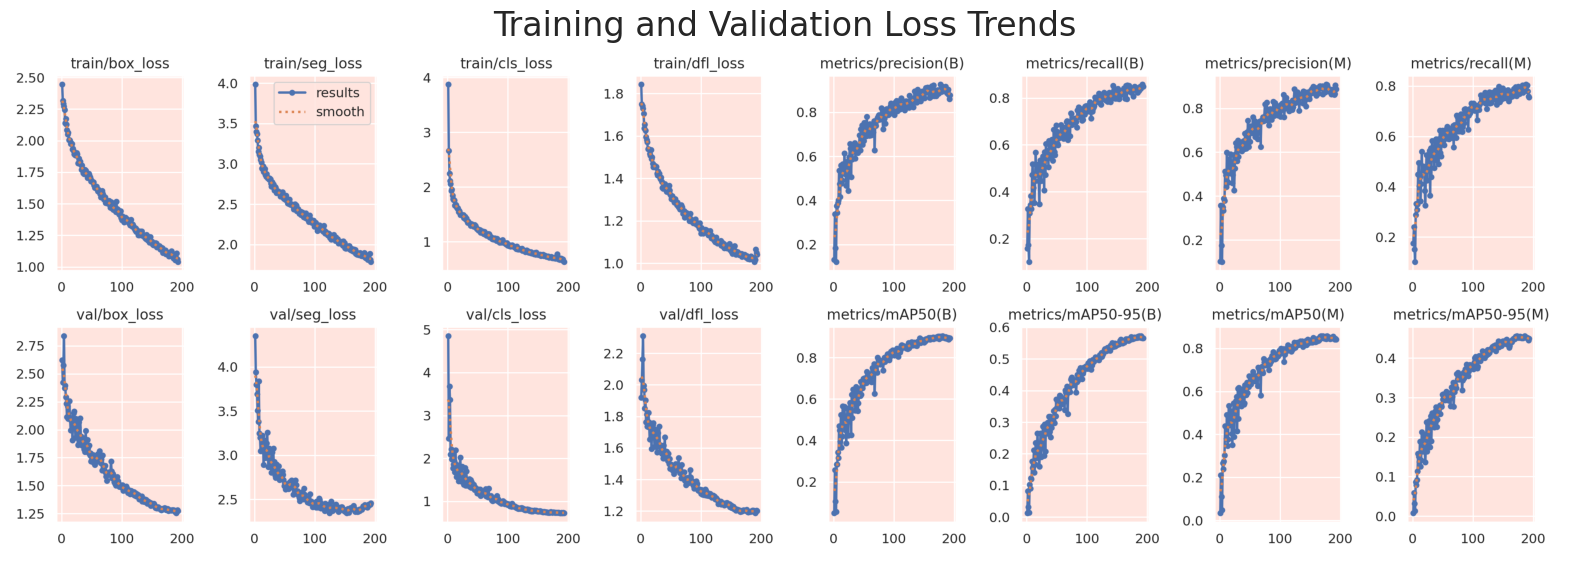

In [14]:
import cv2  
# Create the full file path by joining the directory path with the filename
results_file_path = os.path.join(post_training_files_path,'results.png')

# Read the image using cv2
image = cv2.imread(results_file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

# Display the image using matplotlib
plt.figure(figsize=(20, 8))
plt.imshow(image)
plt.title('Training and Validation Loss Trends', fontsize=24)
plt.axis('off') 
plt.show()

In [16]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title, ylim_range=[0,2]):
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='blue', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='#ed2f00', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(ylim_range)
    plt.legend()
    plt.show()

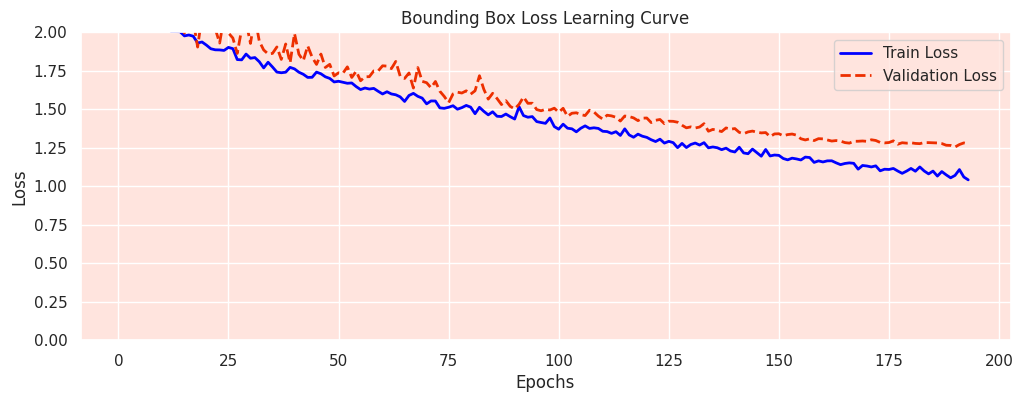

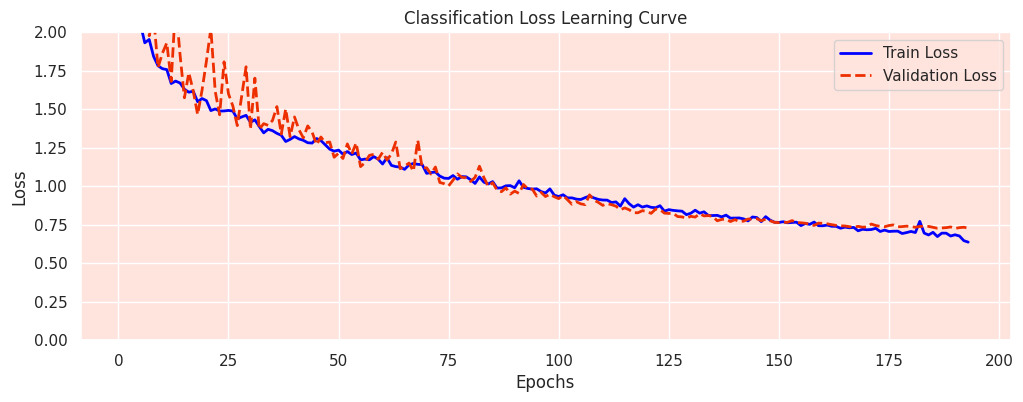

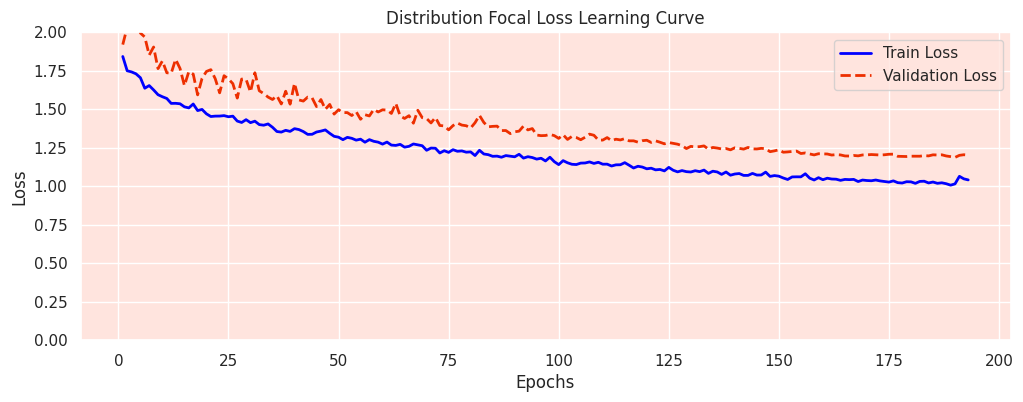

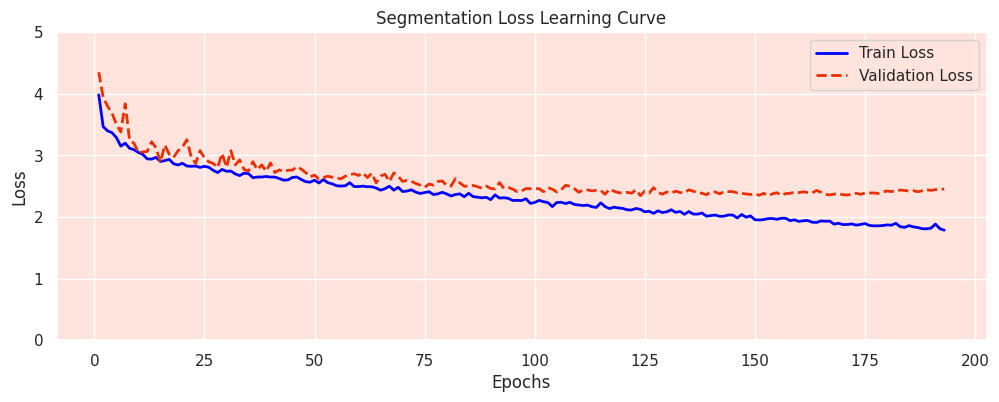

In [17]:
# Create the full file path for 'results.csv' using the directory path and file name
results_csv_path = os.path.join(post_training_files_path, 'results.csv')

# Load the CSV file from the constructed path into a pandas DataFrame
df = pd.read_csv(results_csv_path)

# Remove any leading whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Bounding Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')
plot_learning_curve(df, 'train/seg_loss', 'val/seg_loss', 'Segmentation Loss Learning Curve', ylim_range=[0,5])

<a id="Confidence_Threshold_Metrics"></a>
# <b><span style='color:#ffbaab'>Step 5.2 |</span><span style='color:#ed2f00'> Confidence Threshold Metrics Analysis</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

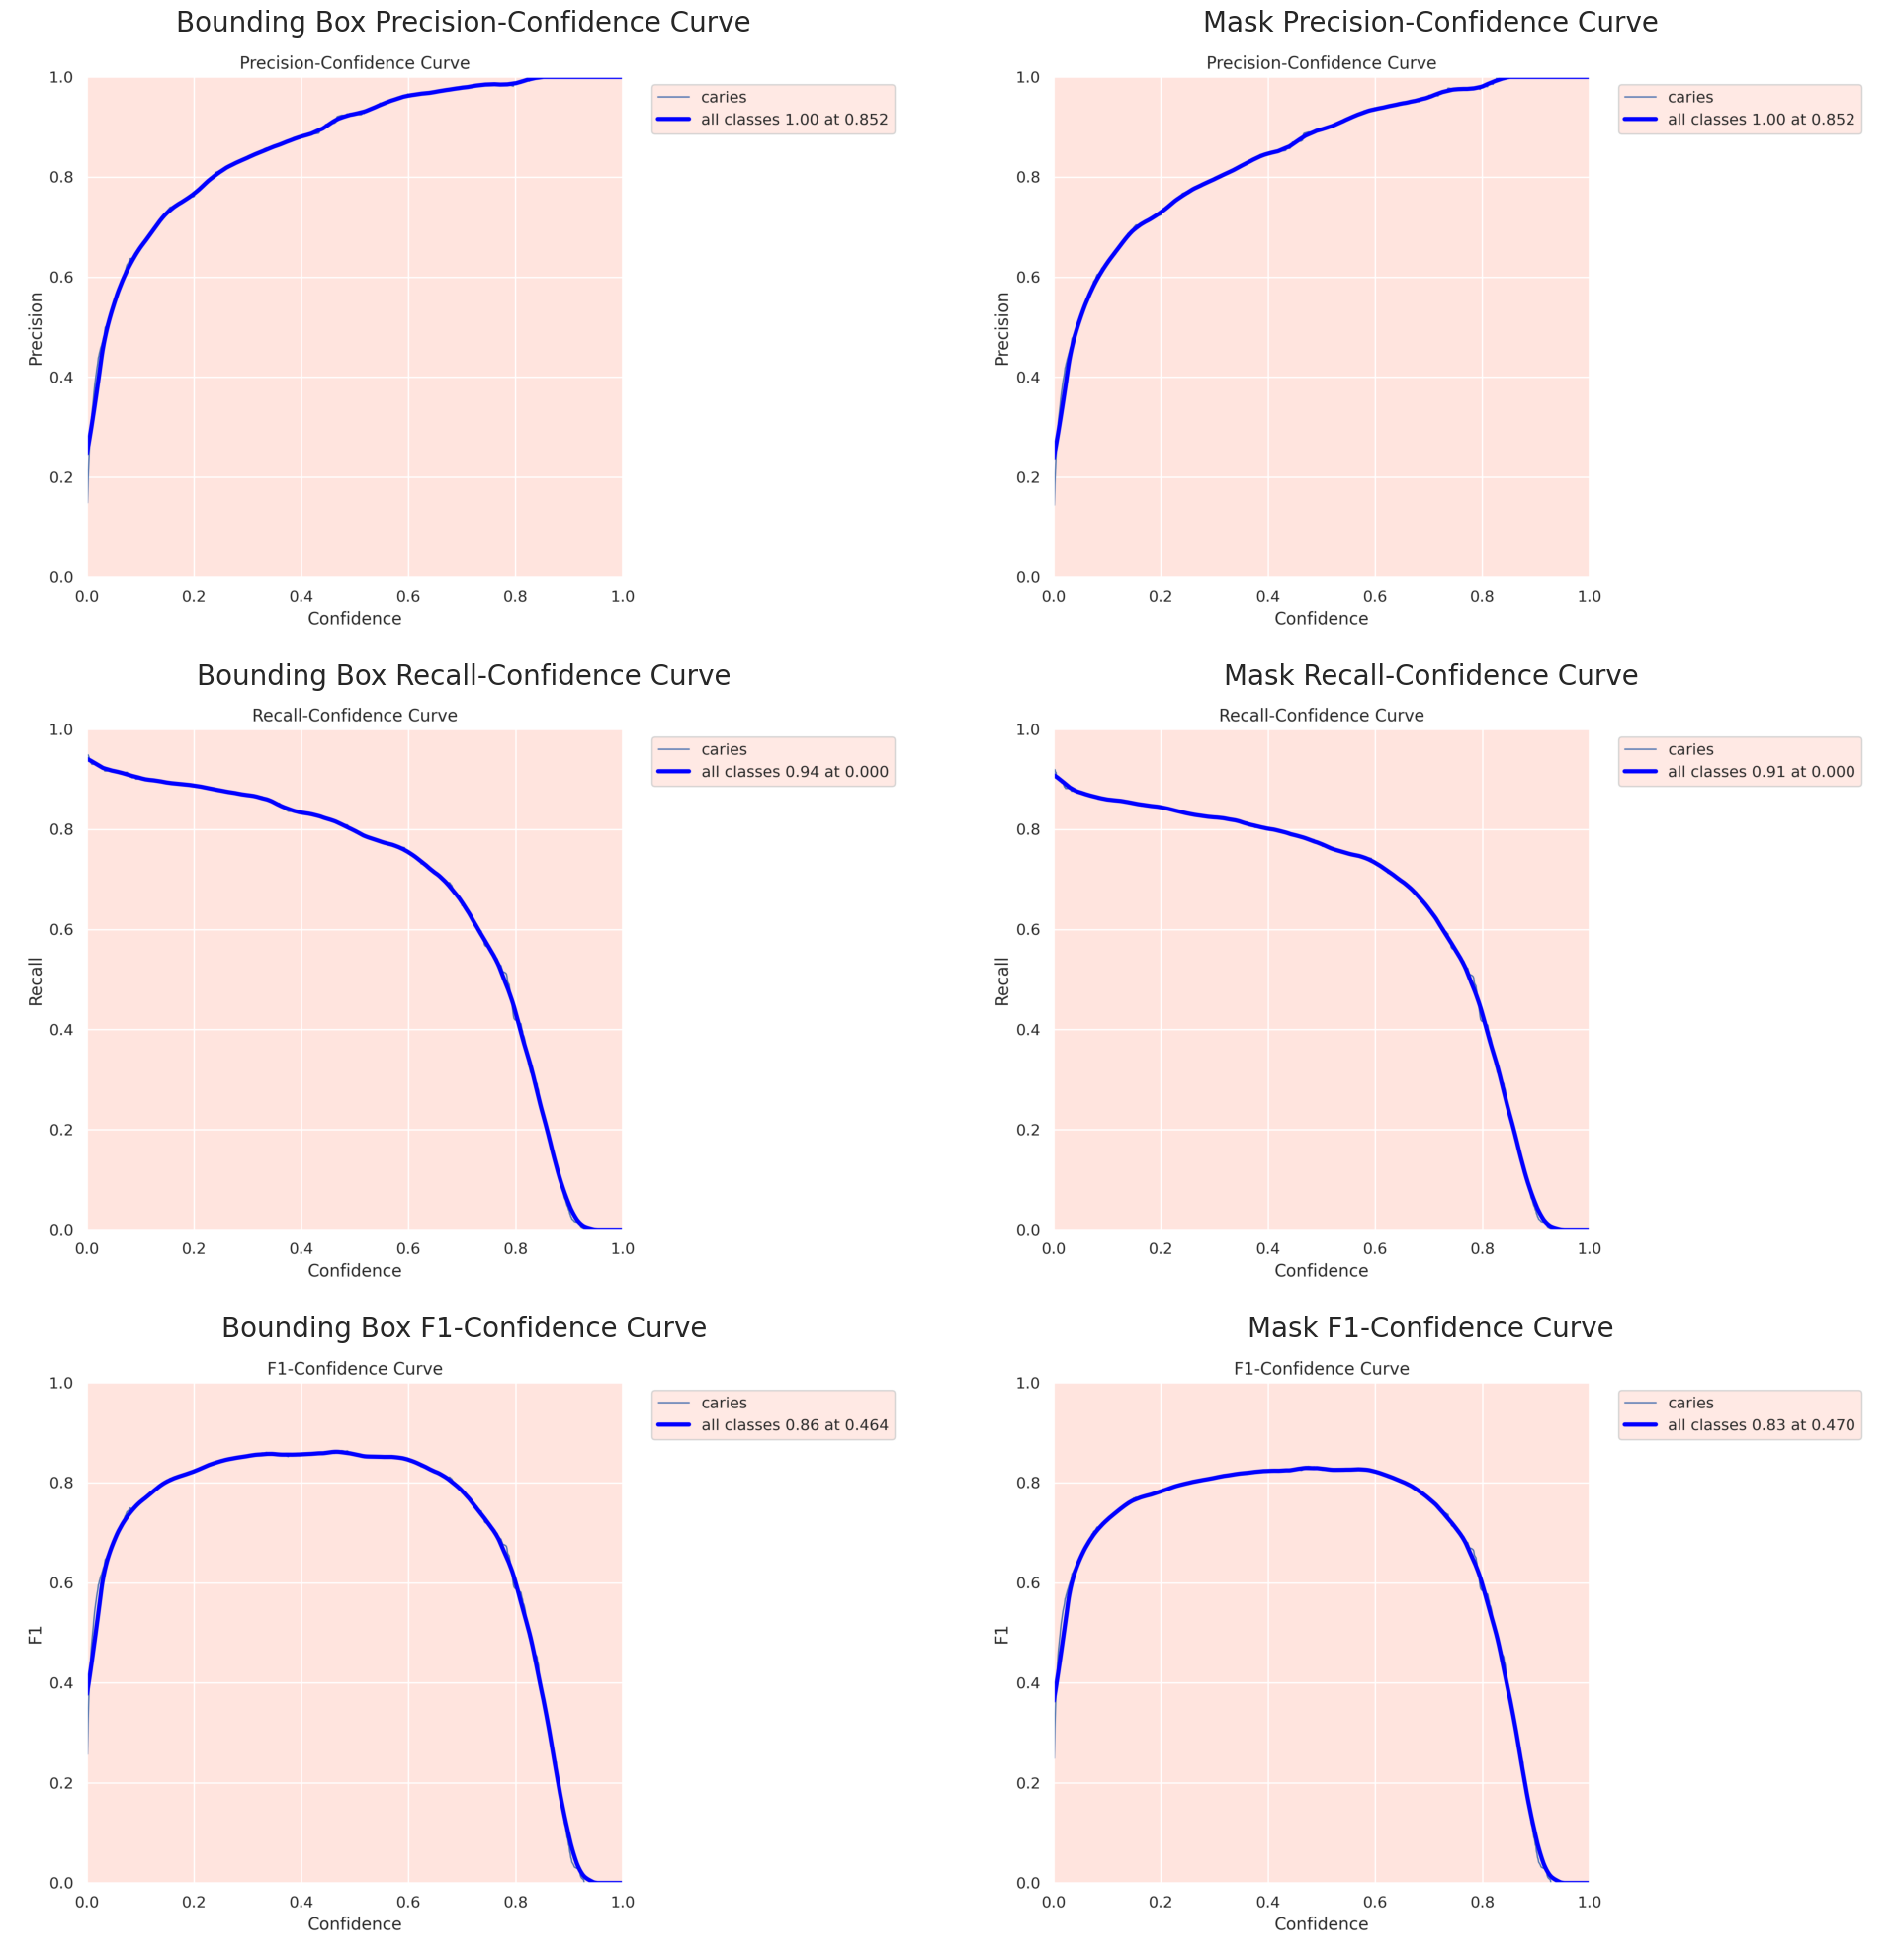

In [18]:
# Define the filenames for 'Box' and 'Mask' metrics along with their titles
box_files_titles = {
    'BoxP_curve.png': 'Bounding Box Precision-Confidence Curve',
    'BoxR_curve.png': 'Bounding Box Recall-Confidence Curve',
    'BoxF1_curve.png': 'Bounding Box F1-Confidence Curve'
}
mask_files_titles = {
    'MaskP_curve.png': 'Mask Precision-Confidence Curve',
    'MaskR_curve.png': 'Mask Recall-Confidence Curve',
    'MaskF1_curve.png': 'Mask F1-Confidence Curve'
}

# Create a 3x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# Function to read and convert image for plotting
def read_and_convert_image(file_path):
    # Read the image using cv2
    image = cv2.imread(file_path)
    # Convert from BGR to RGB
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot 'Box' images in the first column with meaningful titles
for i, (filename, title) in enumerate(box_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(title, fontsize=20)
    axs[i, 0].axis('off') 

# Plot 'Mask' images in the second column with meaningful titles
for i, (filename, title) in enumerate(mask_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(title, fontsize=20)
    axs[i, 1].axis('off')  

plt.tight_layout()
plt.show()

<a id="Precision_Recall_Curve"></a>
# <b><span style='color:#ffbaab'>Step 5.3 |</span><span style='color:#ed2f00'> Precision-Recall Curve Analysis</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

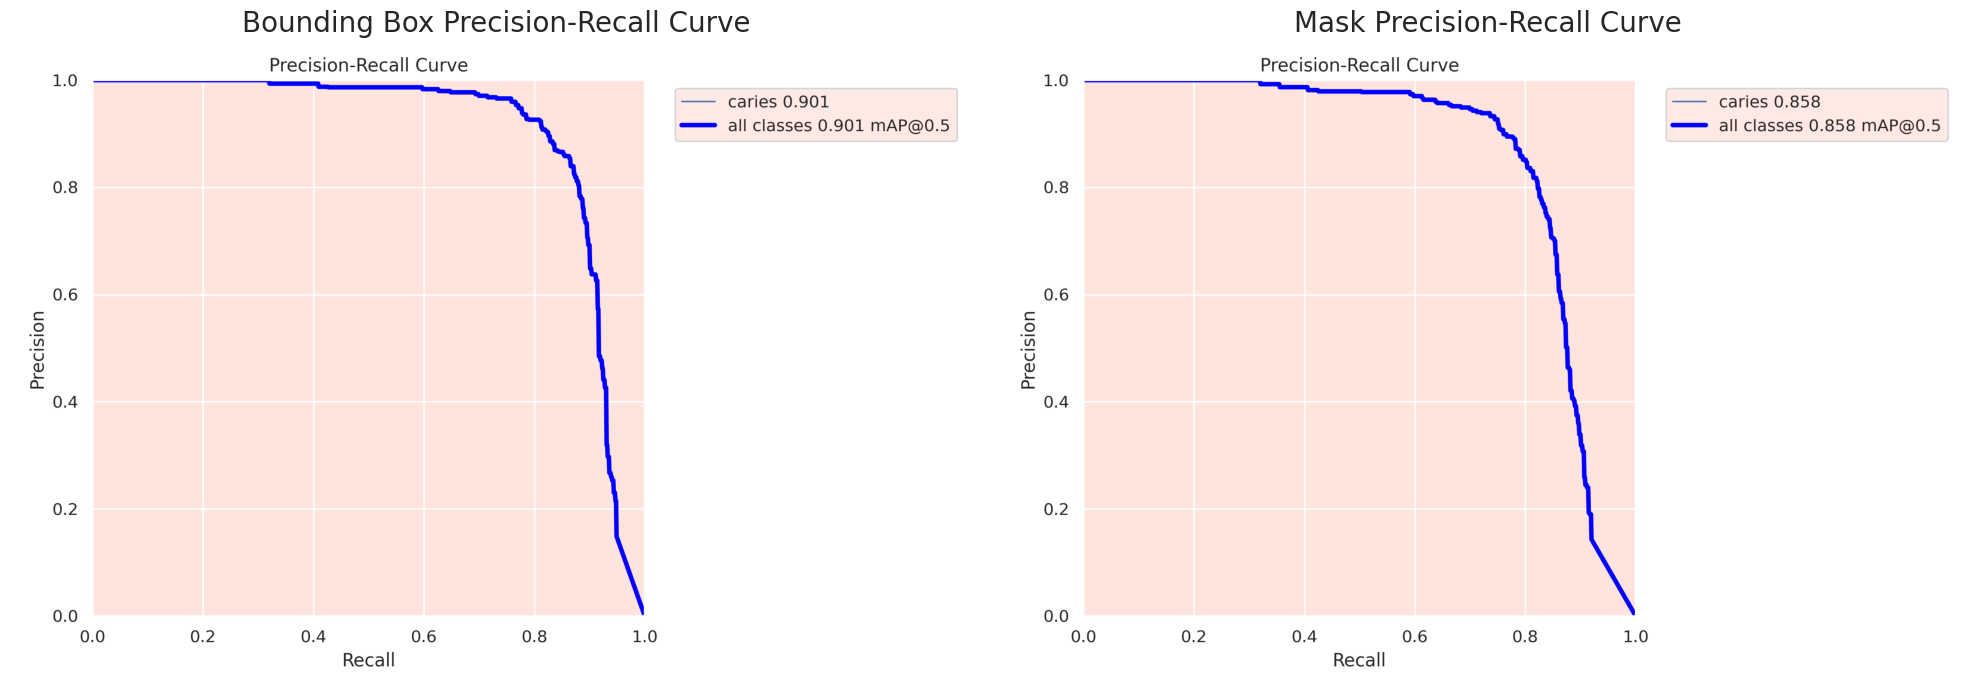

In [19]:
# Define the filenames for 'Box' and 'Mask' metrics along with their titles
pr_files_titles = {
    'BoxPR_curve.png': 'Bounding Box Precision-Recall Curve',
    'MaskPR_curve.png': 'Mask Precision-Recall Curve'
}

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot 'Box' and 'Mask' images in the subplot with meaningful titles
for i, (filename, title) in enumerate(pr_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=20)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

<a id="Confusion_Matrix"></a>
# <b><span style='color:#ffbaab'>Step 5.4 |</span><span style='color:#ed2f00'> Confusion Matrix Analysis</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

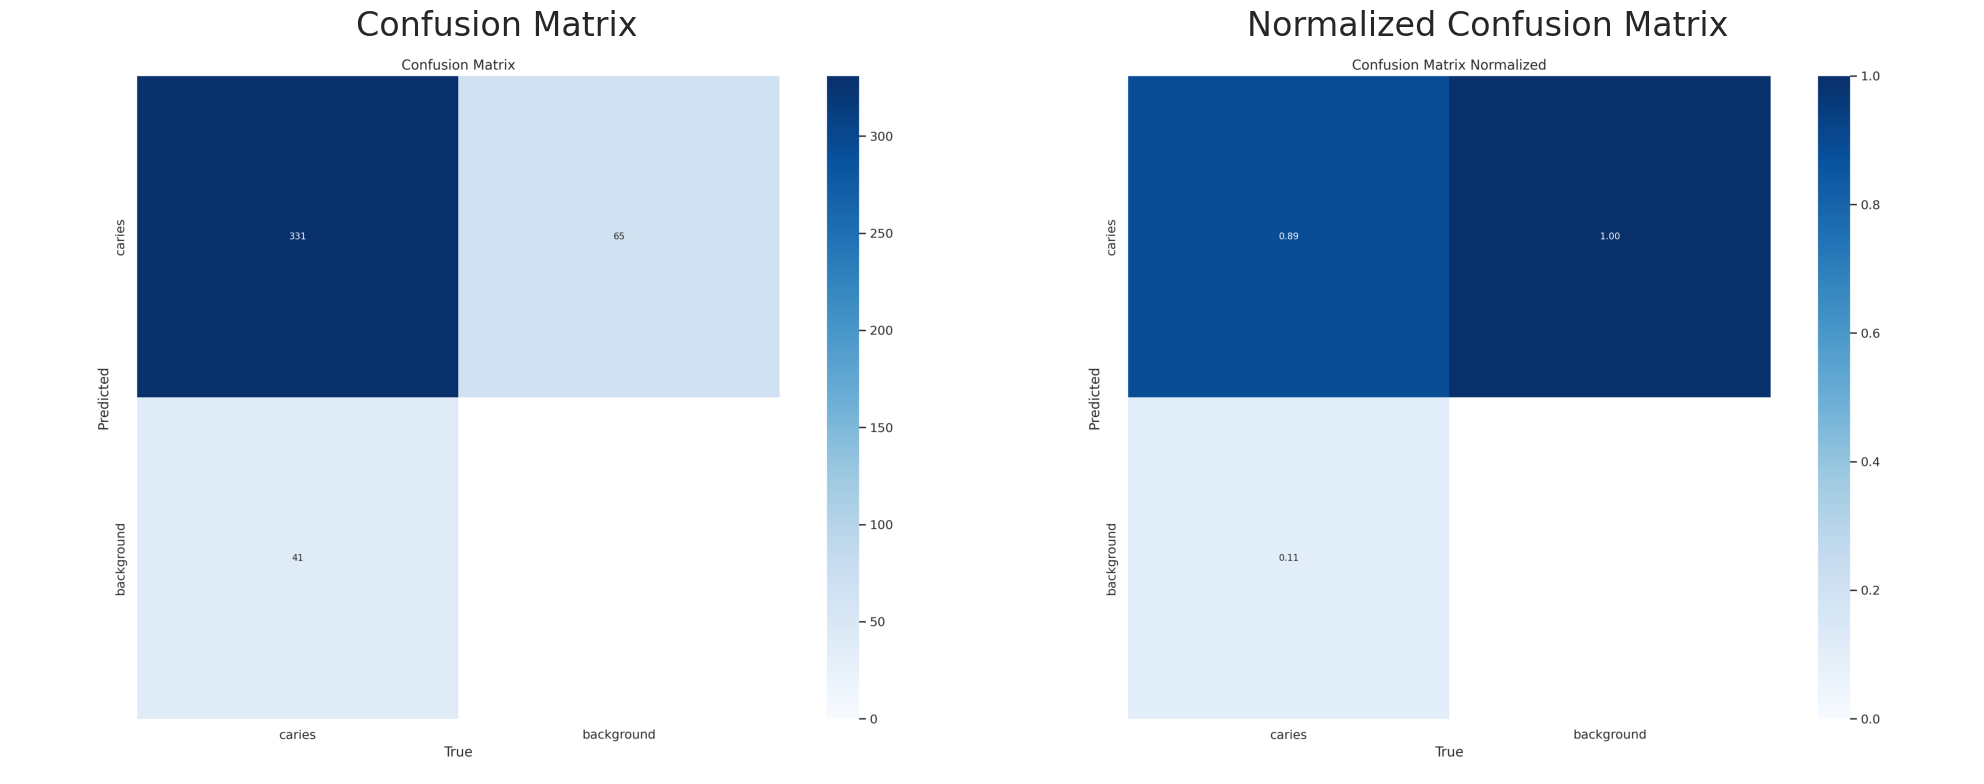

In [20]:
# Construct the path to the confusion matrix images
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix.png')
confusion_matrix_normalized_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Read and convert both images
cm_img = read_and_convert_image(confusion_matrix_path)
cm_norm_img = read_and_convert_image(confusion_matrix_normalized_path)

# Display the images
axs[0].imshow(cm_img)
axs[0].set_title('Confusion Matrix', fontsize=24)
axs[0].axis('off') 

axs[1].imshow(cm_norm_img)
axs[1].set_title('Normalized Confusion Matrix', fontsize=24)
axs[1].axis('off')

plt.tight_layout()
plt.show()

<a id="Performance_Metrics"></a>
# <b><span style='color:#ffbaab'>Step 5.5 |</span><span style='color:#ed2f00'> Validation Performance Metrics Assessment</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

In [22]:
# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


val: Scanning /kaggle/input/dentalcariesv1/seg_detection_caries/valid/labels... 205 images, 0 backgrounds, 2 corrupt: 100%|██████████| 205/205 [00:00<00:00, 899.91it/s]

val: WARNING ⚠️ /kaggle/input/dentalcariesv1/seg_detection_caries/valid/images/Screenshot-2023-11-16-at-12-27-47-AM_png_jpg.rf.8b2438d7e32a663c3f43501dee323b20.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/input/dentalcariesv1/seg_detection_caries/valid/images/Screenshot-2023-11-27-at-12-15-06-PM_png_jpg.rf.200d208b599f2a7705dfbf5c69386572.jpg: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ Cache directory /kaggle/input/dentalcariesv1/seg_detection_caries/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


                   all        203        372        0.9      0.819      0.901      0.572      0.886      0.772      0.852      0.452
Speed: 1.4ms preprocess, 3.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/val2


In [24]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# Display the DataFrame
metrics_df.round(3)

Metric Value
metrics/precision(B)         0.900
metrics/recall(B)            0.819
metrics/mAP50(B)             0.901
metrics/mAP50-95(B)          0.572
metrics/precision(M)         0.886
metrics/recall(M)            0.772
metrics/mAP50(M)             0.852
metrics/mAP50-95(M)          0.452
fitness                      1.097

<a id="Model_Inference"></a>
# <p style="background-color: #ed2f00; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;"> Step 6 | Model Inference</p>
⬆️ [Tabel of Contents](#contents_tabel)

<a id="Inference_Images"></a>
# <b><span style='color:#ffbaab'>Step 6.1 |</span><span style='color:#ed2f00'> Inference on Validation Images</span></b>
⬆️ [Tabel of Contents](#contents_tabel)


image 1/1 /kaggle/input/dentalcariesv1/seg_detection_caries/valid/images/Screenshot-2023-11-19-at-10-18-54-AM_png_jpg.rf.1a57d278c7f2e71107a83aa69b91c42a.jpg: 640x640 5 cariess, 9.2ms
Speed: 1.5ms preprocess, 9.2ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/dentalcariesv1/seg_detection_caries/valid/images/Screenshot-2023-11-27-at-12-17-11-PM_png_jpg.rf.f6bba43928a953070b6871e3b5457cff.jpg: 640x640 1 caries, 9.0ms
Speed: 1.4ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/dentalcariesv1/seg_detection_caries/valid/images/Screenshot-2023-11-24-at-1-09-41-AM_png_jpg.rf.fc7f96ec7f675229c8f22bc53848a363.jpg: 640x640 4 cariess, 8.6ms
Speed: 1.2ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/dentalcariesv1/seg_detection_caries/valid/images/Screenshot-2023-11-16-at-12-31-22-AM_png_jpg.rf.5c0ade65867922afa92534d211332424.jpg

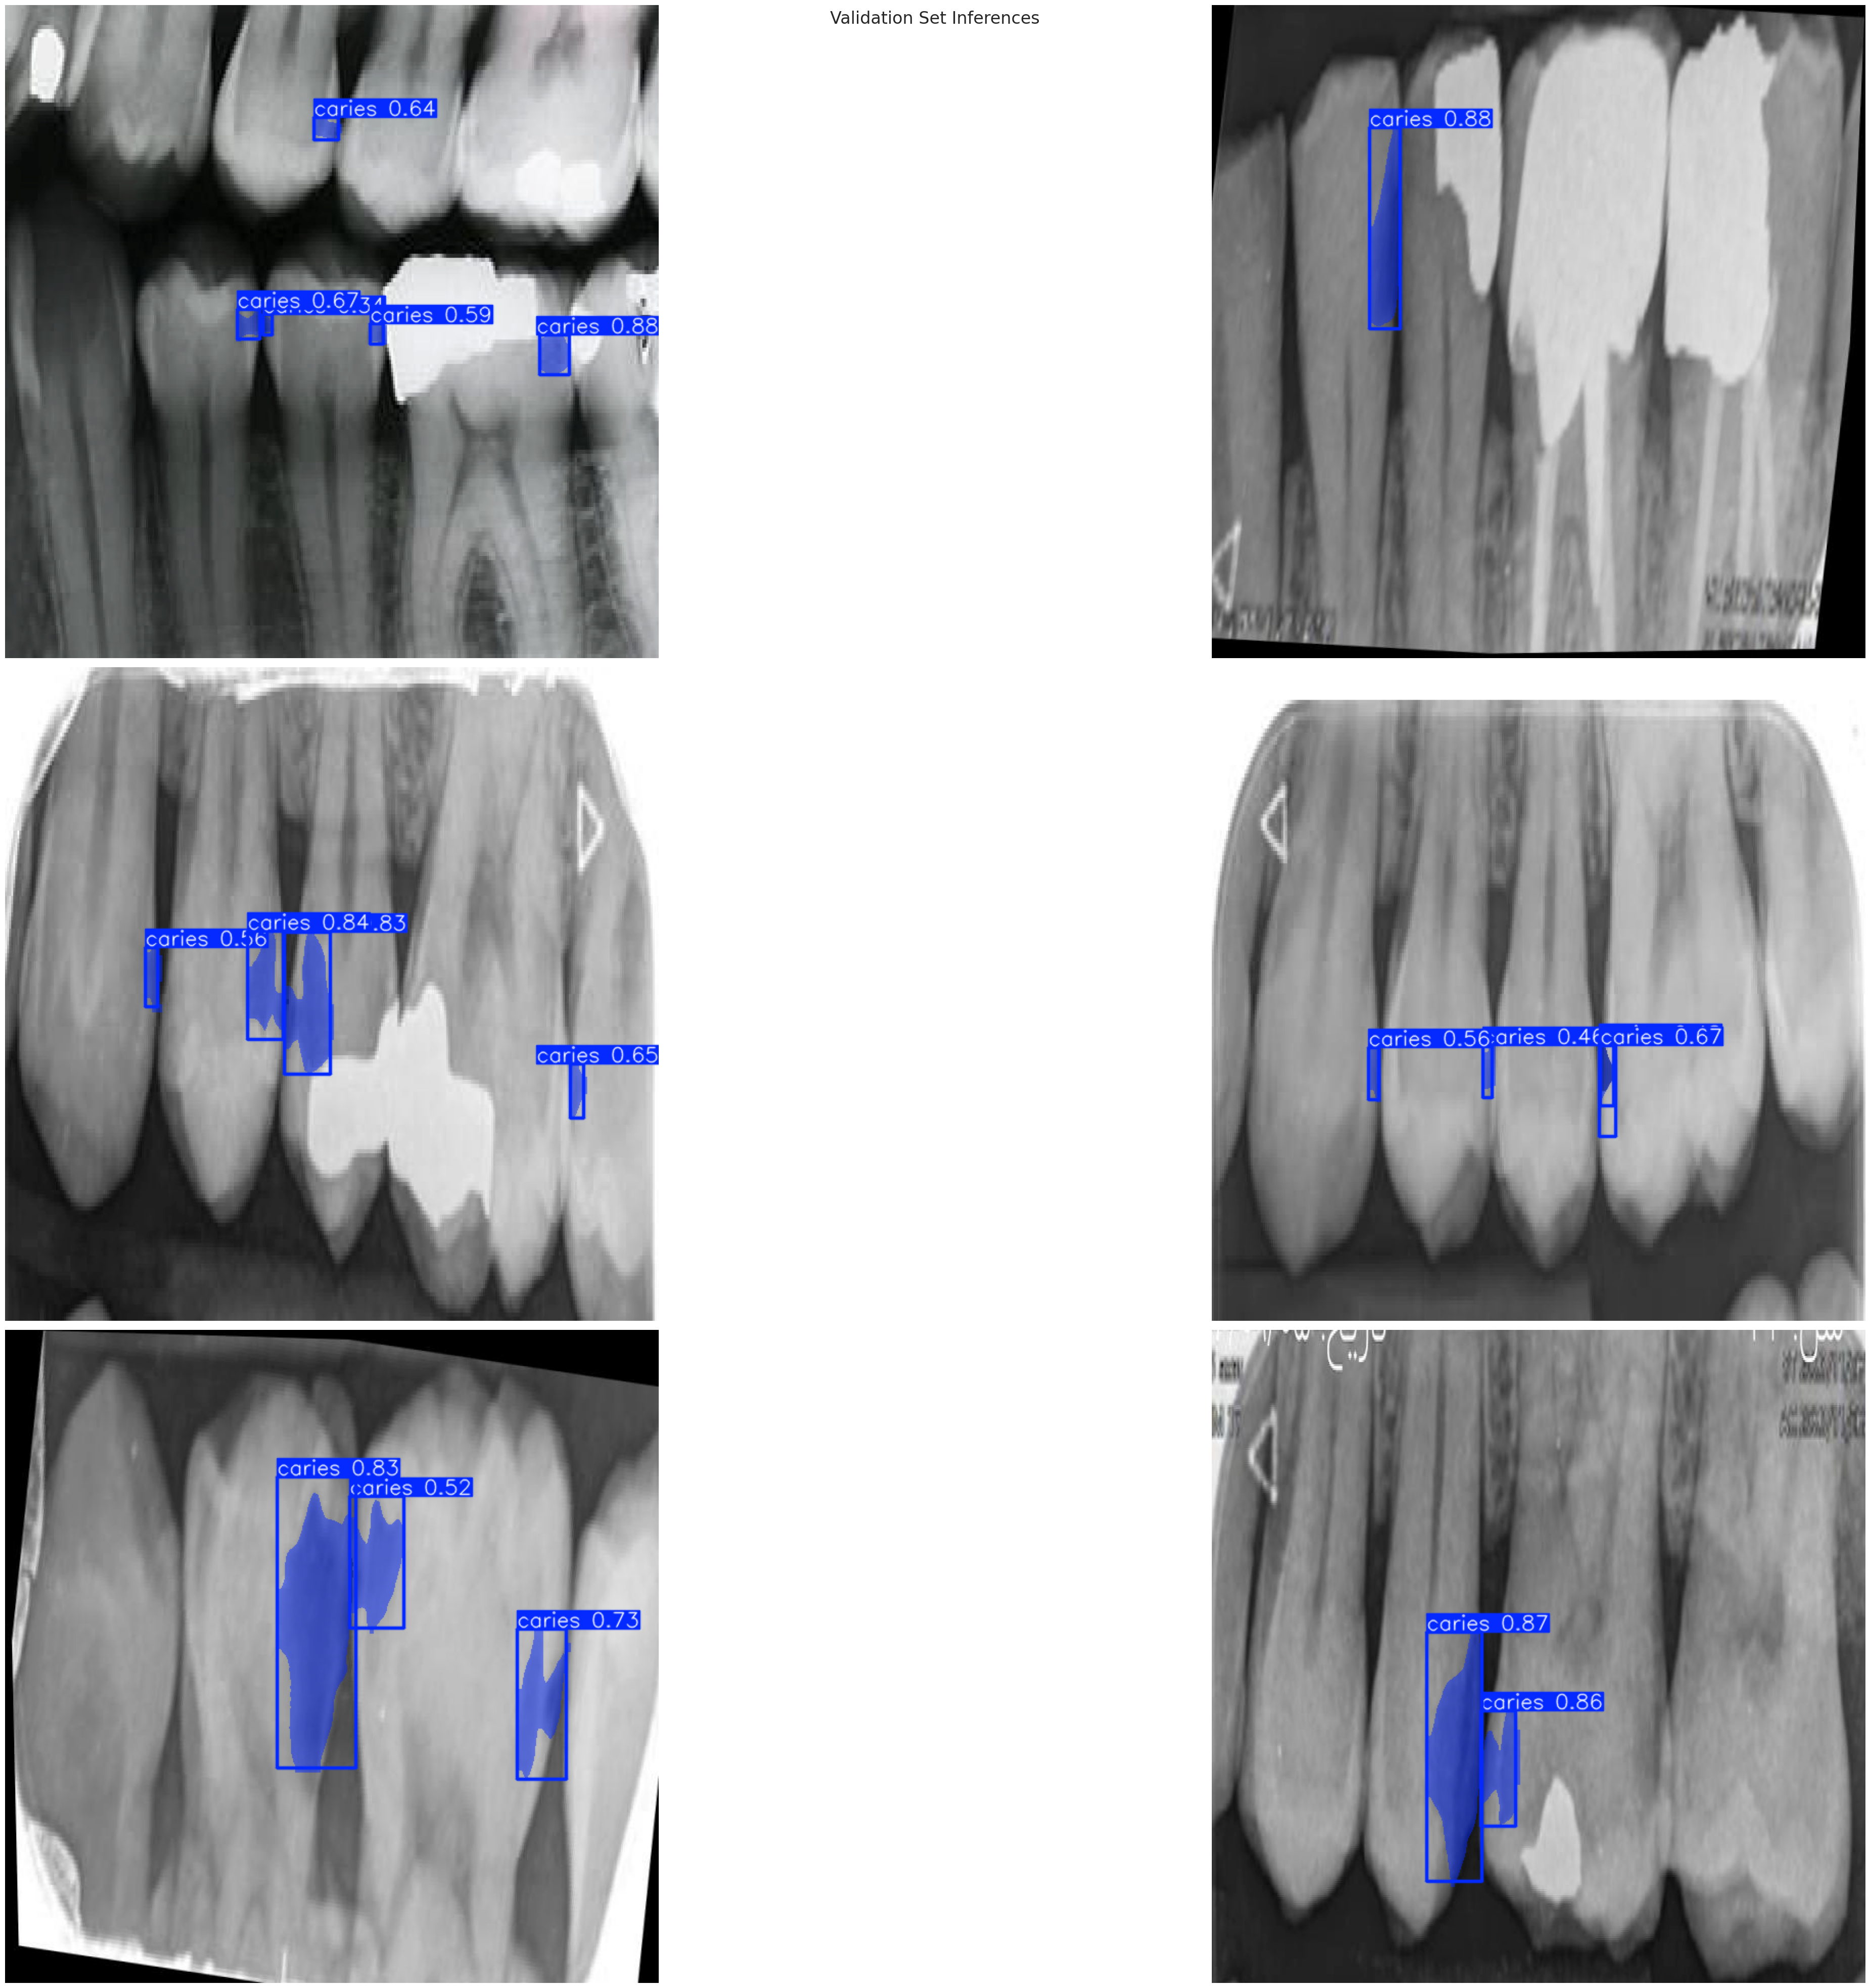

In [25]:
# Define the path to the validation images
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select 9 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 9)]

# Initialize the subplot
fig, axes = plt.subplots(3, 2, figsize=(60, 40))
fig.suptitle('Validation Set Inferences', fontsize=24)

# Perform inference on each selected image and display it
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(valid_images_path, selected_images[i])
    results = best_model.predict(source=image_path, imgsz=640)
    annotated_image = results[0].plot()
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    ax.imshow(annotated_image_rgb)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [26]:
# Export the model
best_model.export(format='onnx')

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.0.0 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from '/kaggle/working/runs/segment/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (5.7 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
  Obtaining dependency information for onnxslim from https://files.pythonhosted.org/packages/0c/89/3b9acb813e7c520a5aa8c2edba48bb4bc07410e7110a7357c93970ca7001/onnxslim-0.1.39-py3-none-any.whl.metadata
  Obtaining dependency information for onnxruntime-gpu from https://files.pythonhosted.org/packages/06/24/ba71597b90802853d768e5598739a06a96600658df679ee1a7aa2b1ba335/onnxruntime_gpu-1.20.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for coloredlogs from https://files.pythonhosted.org/packages/a7/06/3d6badcf13db419e25b07041d9c7b4a2c331d3f4e7134445ec5df57714cd/coloredlogs-15.0

'/kaggle/working/runs/segment/train/weights/best.onnx'

<a id="Model_Performance"></a>
# <p style="background-color: #ed2f00; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;"> Step 7 | GRADCAM </p>
⬆️ [Tabel of Contents](#contents_tabel)

In [115]:
!cp -r /kaggle/input/yolo-cam/yolo_cam /kaggle/working/

In [116]:
!pip install grad-cam
!pip install ttach
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image


In [122]:
target_layers =[model.model.model[-7]]


In [123]:
cam = EigenCAM(model, target_layers,task='od')

In [124]:
img = cv2.imread('/kaggle/input/dental-caries/seg_detection_caries/valid/images/Screenshot-2023-11-24-at-6-32-08-PM_png_jpg.rf.819b43c23aeba6096003fb3216688cdb.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [125]:
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

AttributeError: 'tuple' object has no attribute 'cpu'

In [28]:
out_im = Image.fromarray(cam_image)
out_im.save('test1.png')


0: 640x640 3 cariess, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


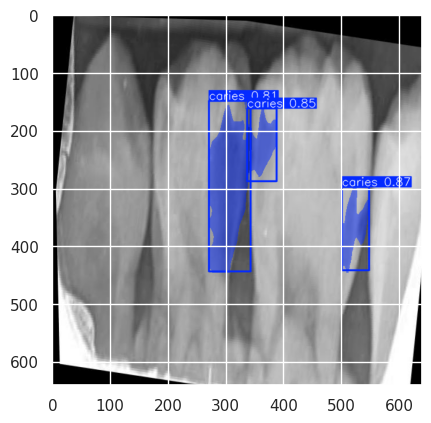

In [29]:

results = best_model.predict(rgb_img , imgsz=640)
annotated_image = results[0].plot()
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
ax.imshow(annotated_image_rgb)
ax.axis('off')

plt.imshow(annotated_image_rgb)
plt.show()


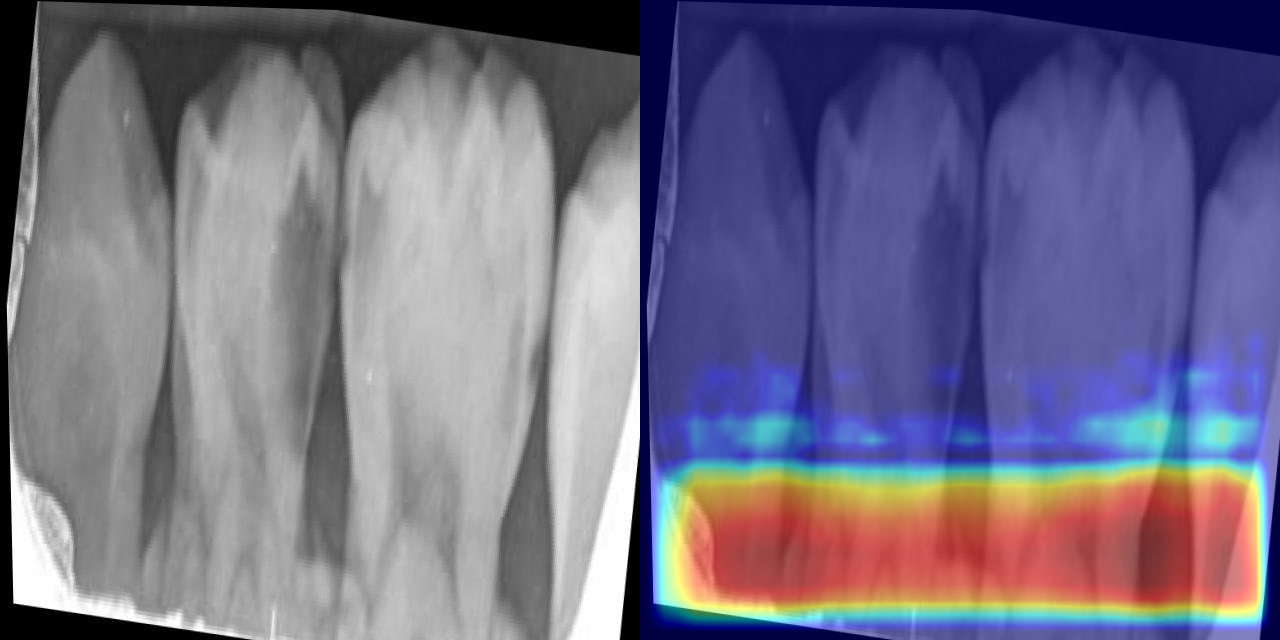

In [30]:
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))

In [31]:
out_im1 = Image.fromarray(im)
out_im1.save('test2.png')
out_im2 = Image.fromarray(cam_image)
out_im2.save('test3.png')

<h2 align="left"><font color=#fd2f00>LIME</font></h2>

In [32]:
pip install scikit-image==0.19.3

  Obtaining dependency information for scikit-image==0.19.3 from https://files.pythonhosted.org/packages/1b/09/88624513508fc56c646aa660193a75c953bb5dae46a2f67891af8d95a5c7/scikit_image-0.19.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 46.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.21.0
    Uninstalling scikit-image-0.21.0:
      Successfully uninstalled scikit-image-0.21.0
Note: you may need to restart the kernel to use updated packages.


In [126]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from ultralytics import YOLO
import torch

# Global variable to store conv4 features
conv4_features = None



# Function to locate the conv4 layer
def get_conv4_layer(model):
    # Print model layers to find conv4
    for i, layer in enumerate(model.model.model):
        print(f"Layer {i}: {layer}")
    # Replace with actual layer index or name
    return model.model.model[17]  # Example: assuming conv4 is at index 4

# Hook function to capture feature maps from conv4
def hook_fn(module, input, output):
    global conv4_features
    conv4_features = output

# Locate conv4 layer and register hook
conv4_layer = get_conv4_layer(model)
hook = conv4_layer.register_forward_hook(hook_fn)

# Define the predict function using YOLO’s output
def predict(images):
    global conv4_features
    outputs = []
    for img in images:
        result = model(img)
        if result is None or len(result[0].boxes) == 0:
            scores = np.array([0.0])
        else:
            # Use the conv4 features to influence prediction
            if conv4_features is not None:
                # Example use of conv4 features
                scores = np.array([conv4_features.mean().item()])
            else:
                scores = np.array([0.0])
        outputs.append(scores)
    return np.array(outputs)

# Initialize LIME
explainer = lime_image.LimeImageExplainer()

try:
    # Load and preprocess the image
    img_path = '/kaggle/input/dental-caries/seg_detection_caries/valid/images/Screenshot-2023-11-24-at-6-32-08-PM_png_jpg.rf.819b43c23aeba6096003fb3216688cdb.jpg'
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not loaded correctly. Check the file path: {img_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (640, 640))  # Ensure image size matches model input

    # Explain the image with LIME
    explanation = explainer.explain_instance(
        img_resized,
        predict,
        top_labels=1,
        hide_color=0,
        num_samples=200
    )

    # Get LIME explanation and mask
    temp, mask = explanation.get_image_and_mask(
        label=0,
        positive_only=False,
        num_features=10,
        hide_rest=False
    )

    # Create the LIME mask with boundaries
    img_with_boundaries = mark_boundaries(temp, mask)
    
    # Create caries mask overlay
    overlay = np.zeros_like(img_resized)
    overlay[mask > 0] = [255, 0, 0]  # Red mask for caries
    
    # Overlay the mask on the original image
    img_with_overlay = cv2.addWeighted(img_resized, 0.7, overlay, 0.3, 0)
    
    # Visualize the LIME explanation with boundaries and caries mask overlay
    plt.figure(figsize=(15, 10))
    
    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_resized)
    plt.title('Original Image')
    
    # Display the LIME explanation with boundaries
    plt.subplot(1, 3, 2)
    plt.imshow(img_with_boundaries)
    plt.title('LIME Explanation with Boundaries')
    
    # Display the image with caries mask overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_with_overlay)
    plt.title('Caries Mask Overlay')
    
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

# Remove hook to avoid side effects
hook.remove()


Layer 0: Conv(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (act): SiLU(inplace=True)
)
Layer 1: Conv(
  (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (act): SiLU(inplace=True)
)
Layer 2: C2f(
  (cv1): Conv(
    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (m): ModuleList(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
  )
)
Layer 3: Conv(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (act): SiLU(inplace=True)
)
Layer 4: C2f(
  (cv1): Conv(
    (conv): Conv2d(64, 64, kernel_s

  0%|          | 0/200 [00:00<?, ?it/s]


An error occurred: 'tuple' object has no attribute 'cpu'


<h2 align="left"><font color=#ed2f00>shap</font></h2>

<h2 align="left"><font color=#ed2f00>Best Regards</font></h2>